---
title: "Compare weighting strategy with Inversion of surface Gravity Anomaly Data"
authors:
  - id: thibautastic
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

Here we invert gravity anomaly data to recover a density contrast model. We formulate the inverse problem as an iteratively
re-weighted least-squares (IRLS) optimization problem. For this tutorial, we
focus on the following:

1. Setting regularization weights
2. Defining the survey from xyz formatted data
3. Generating a mesh based on survey geometry
4. Including surface topography
5. Defining the inverse problem (data misfit, regularization, optimization)
6. Specifying directives for the inversion
7. Setting sparse and blocky norms
8. Plotting the recovered model and data misfit

Although we consider gravity anomaly data in this tutorial, the same approach
can be used to invert gradiometry and other types of geophysical data.

Import modules
--------------


In [1]:
import os
import tarfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from discretize import TensorMesh
from discretize.utils import active_from_xyz

from simpeg import (
    data,
    data_misfit,
    directives,
    inverse_problem,
    inversion,
    maps,
    optimization,
    regularization,
    utils,
)
from simpeg.potential_fields import gravity
from simpeg.utils import model_builder, plot2Ddata

Define File Names
-----------------

File paths for assets we are loading. To set up the inversion, we require
topography and field observations. The true model defined on the whole mesh
is loaded to compare with the inversion result. These files are stored as a
tar-file on our google cloud bucket:
"https://storage.googleapis.com/simpeg/doc-assets/gravity.tar.gz"


In [2]:
# storage bucket where we have the data
data_source = "https://storage.googleapis.com/simpeg/doc-assets/gravity.tar.gz"

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "gravity_topo.txt"
data_filename = dir_path + "gravity_data.obs"

   saved to: /home/ssoler/git/user-tutorials/notebooks/03-gravity/gravity.tar.gz
Download completed!


/tmp/ipykernel_971017/1191307735.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Load Data and Plot
------------------

Here we load and plot synthetic gravity anomaly data. Topography is generally
defined as an (N, 3) array. Gravity data is generally defined with 4 columns:
x, y, z and data.


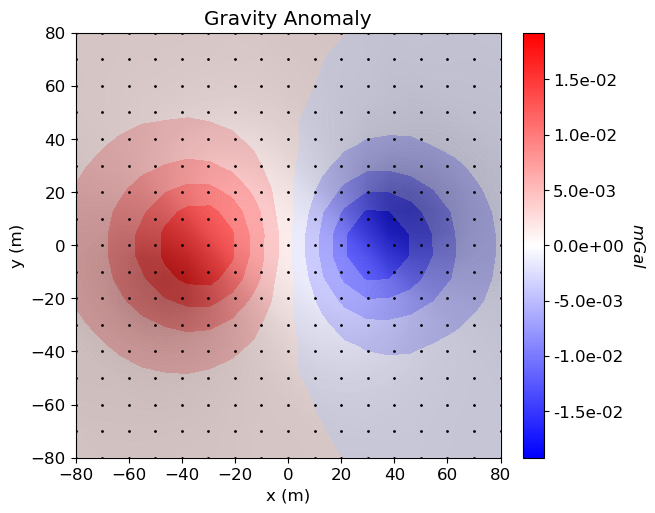

In [3]:
# Load topography
xyz_topo = np.loadtxt(str(topo_filename))

# Load field data
dobs = np.loadtxt(str(data_filename))

# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    contourOpts={"cmap": "bwr"},
    shade=True,
    nx=20,
    ny=20,
    dataloc=True,
)
ax1.set_title("Gravity Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=np.max(np.abs(dobs)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mGal$", rotation=270, labelpad=15, size=12)

plt.show()

Assign Uncertainties
--------------------

Inversion with simpeg requires that we define the standard deviation of our data.
This represents our estimate of the noise in our data. For a gravity inversion,
a constant floor value is generally applied to all data. For this tutorial,
the standard deviation on each datum will be 1% of the maximum observed
gravity anomaly value.


In [4]:
maximum_anomaly = np.max(np.abs(dobs))

uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs))

Defining the Survey
-------------------

Here, we define the survey that will be used for this tutorial. Gravity
surveys are simple to create. The user only needs an (N, 3) array to define
the xyz locations of the observation locations. From this, the user can
define the receivers and the source field.


In [5]:
# Define the receivers. The data consists of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")

receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

Defining the Data
-----------------

Here is where we define the data that is inverted. The data is defined by
the survey, the observation values and the standard deviation.


In [6]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

Defining a Tensor Mesh
----------------------

Here, we create the tensor mesh that will be used to invert gravity anomaly
data. If desired, we could define an OcTree mesh.


In [7]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

Starting/Reference Model and Mapping on Tensor Mesh
---------------------------------------------------

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures.


In [8]:
# Find the indices of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = np.zeros(nC)

Define the Physics and data misfit
----------------------------------

Here, we define the physics of the gravity problem by using the simulation
class.


In [9]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey, mesh=mesh, rhoMap=model_map, active_cells=ind_active
)

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

Running the Depth Weighted inversion
------------------------------------

Here we define the directives, weights, regularization, and optimization
for a depth-weighted inversion


In [10]:
# inversion directives
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    irls_cooling_factor=1.5,
    misfit_tolerance=1e-2,
)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# The directives are defined as a list
directives_list = [
    update_IRLS,
    starting_beta,
    save_iteration,
    update_jacobi,
]

# Define the regularization (model objective function) with depth weighting.
reg_dpth = regularization.Sparse(mesh, active_cells=ind_active, mapping=model_map)
reg_dpth.norms = [0, 2, 2, 2]
depth_weights = utils.depth_weighting(
    mesh, receiver_locations, active_cells=ind_active, exponent=2
)
reg_dpth.set_weights(depth_weights=depth_weights)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg_dpth, opt)

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model_dpth = inv.run(starting_model)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.78e+02  2.66e+05  0.00e+00  2.66e+05    2.19e+02      0              


   1  4.89e+02  3.19e+03  1.71e+01  1.16e+04    2.10e+02      0              


   2  2.44e+02  1.21e+03  1.99e+01  6.07e+03    2.04e+02      0   Skip BFGS  


   3  1.22e+02  4.61e+02  2.20e+01  3.15e+03    1.93e+02      0   Skip BFGS  


Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 0.05928551292065909


   4  1.22e+02  1.83e+02  4.61e+01  5.82e+03    2.06e+02      0   Skip BFGS  


   5  1.50e+02  2.53e+02  5.92e+01  9.16e+03    2.12e+02      0              


   6  8.26e+01  4.75e+02  6.48e+01  5.83e+03    2.03e+02      0              


   7  1.05e+02  2.39e+02  6.72e+01  7.28e+03    2.14e+02      0              


   8  6.21e+01  3.97e+02  5.96e+01  4.10e+03    2.10e+02      0              


   9  8.13e+01  2.25e+02  5.22e+01  4.47e+03    2.15e+02      0              


  10  9.84e+01  2.61e+02  4.39e+01  4.58e+03    2.16e+02      0              


  11  6.43e+01  3.07e+02  3.79e+01  2.74e+03    2.08e+02      0              


  12  9.10e+01  1.92e+02  3.32e+01  3.21e+03    2.17e+02      0   Skip BFGS  


  13  1.11e+02  2.57e+02  2.73e+01  3.29e+03    2.17e+02      0              


  14  7.24e+01  3.07e+02  2.30e+01  1.97e+03    2.03e+02      0              


  15  9.85e+01  2.08e+02  2.14e+01  2.32e+03    2.18e+02      0   Skip BFGS  


  16  1.21e+02  2.55e+02  1.85e+01  2.49e+03    2.18e+02      0              


  17  8.00e+01  2.93e+02  1.64e+01  1.60e+03    2.04e+02      0              


  18  1.06e+02  2.19e+02  1.62e+01  1.94e+03    2.18e+02      0   Skip BFGS  


  19  1.29e+02  2.60e+02  1.48e+01  2.17e+03    2.18e+02      0              


  20  1.50e+02  2.79e+02  1.36e+01  2.32e+03    2.18e+02      0              


  21  1.73e+02  2.85e+02  1.28e+01  2.50e+03    2.18e+02      0   Skip BFGS  


  22  1.99e+02  2.90e+02  1.22e+01  2.72e+03    2.18e+02      0   Skip BFGS  


  23  1.31e+02  2.98e+02  1.18e+01  1.85e+03    1.88e+02      0              


  24  1.72e+02  2.25e+02  1.20e+01  2.28e+03    2.18e+02      0   Skip BFGS  


  25  2.13e+02  2.49e+02  1.15e+01  2.69e+03    2.18e+02      0              


  26  2.55e+02  2.67e+02  1.11e+01  3.09e+03    2.18e+02      0              


  27  3.01e+02  2.72e+02  1.07e+01  3.50e+03    2.18e+02      0              


  28  3.47e+02  2.85e+02  1.05e+01  3.92e+03    2.18e+02      0              


  29  3.99e+02  2.91e+02  1.02e+01  4.37e+03    2.18e+02      0              


  30  2.62e+02  3.04e+02  9.94e+00  2.90e+03    2.08e+02      0              


  31  3.36e+02  2.33e+02  1.01e+01  3.62e+03    2.18e+02      0              


  32  4.08e+02  2.60e+02  9.86e+00  4.28e+03    2.18e+02      0              


  33  4.74e+02  2.81e+02  9.67e+00  4.86e+03    2.18e+02      0              


Reach maximum number of IRLS cycles: 30
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.6622e+04
1 : |xc-x_last| = 2.9311e-02 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 2.1837e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.1837e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     34
------------------------- DONE! -------------------------


Running the Distance Weighted inversion
---------------------------------------

Here we define the directives, weights, regularization, and optimization
for a distance-weighted inversion


In [11]:
# inversion directives
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    irls_cooling_factor=1.5,
    misfit_tolerance=1e-2,
)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# The directives are defined as a list
directives_list = [
    update_IRLS,
    starting_beta,
    save_iteration,
    update_jacobi,
]

# Define the regularization (model objective function) with distance weighting.
reg_dist = regularization.Sparse(mesh, active_cells=ind_active, mapping=model_map)
reg_dist.norms = [0, 2, 2, 2]
distance_weights = utils.distance_weighting(
    mesh, receiver_locations, active_cells=ind_active, exponent=2
)
reg_dist.set_weights(distance_weights=distance_weights)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg_dist, opt)

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model_dist = inv.run(starting_model)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  2.86e+03  2.66e+05  0.00e+00  2.66e+05    2.19e+02      0              


   1  1.43e+03  2.35e+04  1.41e+01  4.37e+04    2.17e+02      0              


   2  7.15e+02  1.05e+04  2.04e+01  2.51e+04    2.15e+02      0   Skip BFGS  


   3  3.57e+02  4.24e+03  2.65e+01  1.37e+04    2.11e+02      0   Skip BFGS  


   4  1.79e+02  1.62e+03  3.15e+01  7.25e+03    2.05e+02      0   Skip BFGS  


   5  8.94e+01  6.17e+02  3.53e+01  3.77e+03    1.96e+02      0   Skip BFGS  


Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 0.05584940363763429


   6  8.94e+01  2.43e+02  7.45e+01  6.90e+03    2.08e+02      0   Skip BFGS  


   7  5.55e+01  3.53e+02  9.54e+01  5.65e+03    2.06e+02      0              


   8  7.31e+01  2.22e+02  1.13e+02  8.51e+03    2.14e+02      0              


   9  4.07e+01  4.59e+02  1.08e+02  4.85e+03    2.05e+02      0              


  10  5.12e+01  2.43e+02  9.71e+01  5.21e+03    2.14e+02      0              


  11  3.39e+01  2.94e+02  8.14e+01  3.05e+03    2.06e+02      0              


  12  4.87e+01  1.85e+02  6.95e+01  3.57e+03    2.16e+02      0   Skip BFGS  


  13  6.40e+01  2.23e+02  5.90e+01  4.00e+03    2.16e+02      0              


  14  7.39e+01  2.84e+02  4.90e+01  3.91e+03    2.16e+02      0              


  15  4.83e+01  3.08e+02  4.11e+01  2.29e+03    2.09e+02      0              


  16  6.72e+01  1.98e+02  3.76e+01  2.72e+03    2.17e+02      0   Skip BFGS  


  17  8.43e+01  2.44e+02  3.26e+01  2.99e+03    2.18e+02      0              


  18  1.06e+02  2.90e+02  2.88e+01  3.34e+03    2.18e+02      0              


  19  6.65e+01  3.40e+02  2.59e+01  2.06e+03    2.14e+02      0              


  20  8.47e+01  2.37e+02  2.54e+01  2.39e+03    2.18e+02      0   Skip BFGS  


  21  1.01e+02  2.66e+02  2.35e+01  2.65e+03    2.18e+02      0              


  22  6.73e+01  2.93e+02  2.22e+01  1.78e+03    2.02e+02      0              


  23  9.04e+01  2.13e+02  2.21e+01  2.21e+03    2.18e+02      0   Skip BFGS  


  24  1.14e+02  2.40e+02  2.08e+01  2.62e+03    2.18e+02      0              


  25  1.39e+02  2.61e+02  1.99e+01  3.01e+03    2.18e+02      0              


  26  1.64e+02  2.72e+02  1.91e+01  3.40e+03    2.18e+02      0              


  27  1.90e+02  2.81e+02  1.85e+01  3.80e+03    2.18e+02      0   Skip BFGS  


  28  2.21e+02  2.92e+02  1.80e+01  4.27e+03    2.18e+02      0              


  29  1.44e+02  3.06e+02  1.77e+01  2.85e+03    2.03e+02      0              


  30  1.87e+02  2.28e+02  1.78e+01  3.57e+03    2.18e+02      0   Skip BFGS  


  31  2.31e+02  2.53e+02  1.74e+01  4.27e+03    2.18e+02      0              


  32  2.71e+02  2.76e+02  1.70e+01  4.88e+03    2.18e+02      0              


  33  1.80e+02  2.92e+02  1.66e+01  3.27e+03    1.56e+02      0              


  34  2.40e+02  2.16e+02  1.67e+01  4.22e+03    2.18e+02      0   Skip BFGS  


  35  2.94e+02  2.54e+02  1.63e+01  5.06e+03    2.18e+02      0              


Reach maximum number of IRLS cycles: 30
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.6622e+04
1 : |xc-x_last| = 4.0755e-02 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 2.1824e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.1824e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     36
------------------------- DONE! -------------------------


Running the Distance Weighted inversion
---------------------------------------

Here we define the directives, weights, regularization, and optimization
for a sensitivity weighted inversion


In [12]:
# inversion directives
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    irls_cooling_factor=1.5,
    misfit_tolerance=1e-2,
)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list
directives_list = [
    update_IRLS,
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_jacobi,
]

# Define the regularization (model objective function) for sensitivity weighting.
reg_sensw = regularization.Sparse(mesh, active_cells=ind_active, mapping=model_map)
reg_sensw.norms = [0, 2, 2, 2]

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg_sensw, opt)

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model_sensw = inv.run(starting_model)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.20e+03  2.66e+05  0.00e+00  2.66e+05    2.19e+02      0              


   1  1.60e+03  1.88e+04  1.15e+01  3.72e+04    2.16e+02      0              


   2  8.00e+02  8.19e+03  1.61e+01  2.11e+04    2.14e+02      0   Skip BFGS  


   3  4.00e+02  3.26e+03  2.03e+01  1.14e+04    2.10e+02      0   Skip BFGS  


   4  2.00e+02  1.24e+03  2.38e+01  5.99e+03    2.00e+02      0   Skip BFGS  


   5  1.00e+02  4.71e+02  2.64e+01  3.11e+03    1.91e+02      0   Skip BFGS  


Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 0.05481358175866103


   6  1.00e+02  1.89e+02  5.44e+01  5.63e+03    2.09e+02      0   Skip BFGS  


   7  1.19e+02  2.68e+02  6.88e+01  8.49e+03    2.14e+02      0              


   8  6.87e+01  4.27e+02  7.46e+01  5.55e+03    1.86e+02      0              


   9  8.75e+01  2.37e+02  7.61e+01  6.90e+03    2.16e+02      0              


  10  5.19e+01  3.97e+02  6.77e+01  3.91e+03    2.08e+02      0              


  11  7.14e+01  2.04e+02  5.95e+01  4.45e+03    2.15e+02      0              


  12  9.04e+01  2.40e+02  5.00e+01  4.75e+03    2.14e+02      0              


  13  5.96e+01  2.99e+02  4.21e+01  2.80e+03    2.16e+02      0              


  14  8.56e+01  1.86e+02  3.68e+01  3.34e+03    2.16e+02      0   Skip BFGS  


  15  1.13e+02  2.20e+02  3.15e+01  3.78e+03    2.17e+02      0              


  16  1.36e+02  2.63e+02  2.73e+01  3.99e+03    2.17e+02      0              


  17  8.97e+01  3.01e+02  2.43e+01  2.48e+03    2.08e+02      0              


  18  1.21e+02  2.11e+02  2.32e+01  3.02e+03    2.18e+02      0   Skip BFGS  


  19  1.49e+02  2.55e+02  2.12e+01  3.41e+03    2.18e+02      0              


  20  9.85e+01  2.95e+02  1.98e+01  2.24e+03    2.05e+02      0              


  21  1.33e+02  2.12e+02  1.94e+01  2.79e+03    2.18e+02      0   Skip BFGS  


  22  1.65e+02  2.47e+02  1.84e+01  3.28e+03    2.18e+02      0              


  23  1.95e+02  2.75e+02  1.75e+01  3.68e+03    2.18e+02      0              


  24  2.24e+02  2.85e+02  1.68e+01  4.05e+03    2.18e+02      0              


  25  1.48e+02  2.98e+02  1.62e+01  2.70e+03    1.93e+02      0              


  26  2.01e+02  2.08e+02  1.62e+01  3.47e+03    2.18e+02      0   Skip BFGS  


  27  2.52e+02  2.46e+02  1.57e+01  4.21e+03    2.18e+02      0              


  28  2.93e+02  2.80e+02  1.54e+01  4.78e+03    2.18e+02      0              


  29  1.93e+02  2.98e+02  1.50e+01  3.19e+03    1.59e+02      0              


  30  2.63e+02  2.09e+02  1.50e+01  4.16e+03    2.18e+02      0   Skip BFGS  


  31  3.26e+02  2.49e+02  1.46e+01  5.01e+03    2.18e+02      0              


  32  3.77e+02  2.83e+02  1.43e+01  5.67e+03    2.18e+02      0              


  33  2.45e+02  3.13e+02  1.40e+01  3.75e+03    2.02e+02      0   Skip BFGS  


  34  3.25e+02  2.18e+02  1.42e+01  4.84e+03    2.18e+02      0              


  35  3.90e+02  2.66e+02  1.39e+01  5.68e+03    2.18e+02      0              


Reach maximum number of IRLS cycles: 30
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.6622e+04
1 : |xc-x_last| = 3.4660e-02 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 2.1800e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.1800e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     36
------------------------- DONE! -------------------------


Recreate True Model
-------------------


In [13]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.2
sphere_density = 0.2

# Define model. Models in simpeg are vector arrays.
true_model = background_density * np.ones(nC)

# You could find the indicies of specific cells within the model and change their
# value to add structures.
ind_block = (
    (mesh.gridCC[ind_active, 0] > -50.0)
    & (mesh.gridCC[ind_active, 0] < -20.0)
    & (mesh.gridCC[ind_active, 1] > -15.0)
    & (mesh.gridCC[ind_active, 1] < 15.0)
    & (mesh.gridCC[ind_active, 2] > -50.0)
    & (mesh.gridCC[ind_active, 2] < -30.0)
)
true_model[ind_block] = block_density

# You can also use simpeg utilities to add structures to the model more concisely
ind_sphere = model_builder.get_indices_sphere(
    np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC
)
ind_sphere = ind_sphere[ind_active]
true_model[ind_sphere] = sphere_density

Plotting True Model and Recovered Models
----------------------------------------


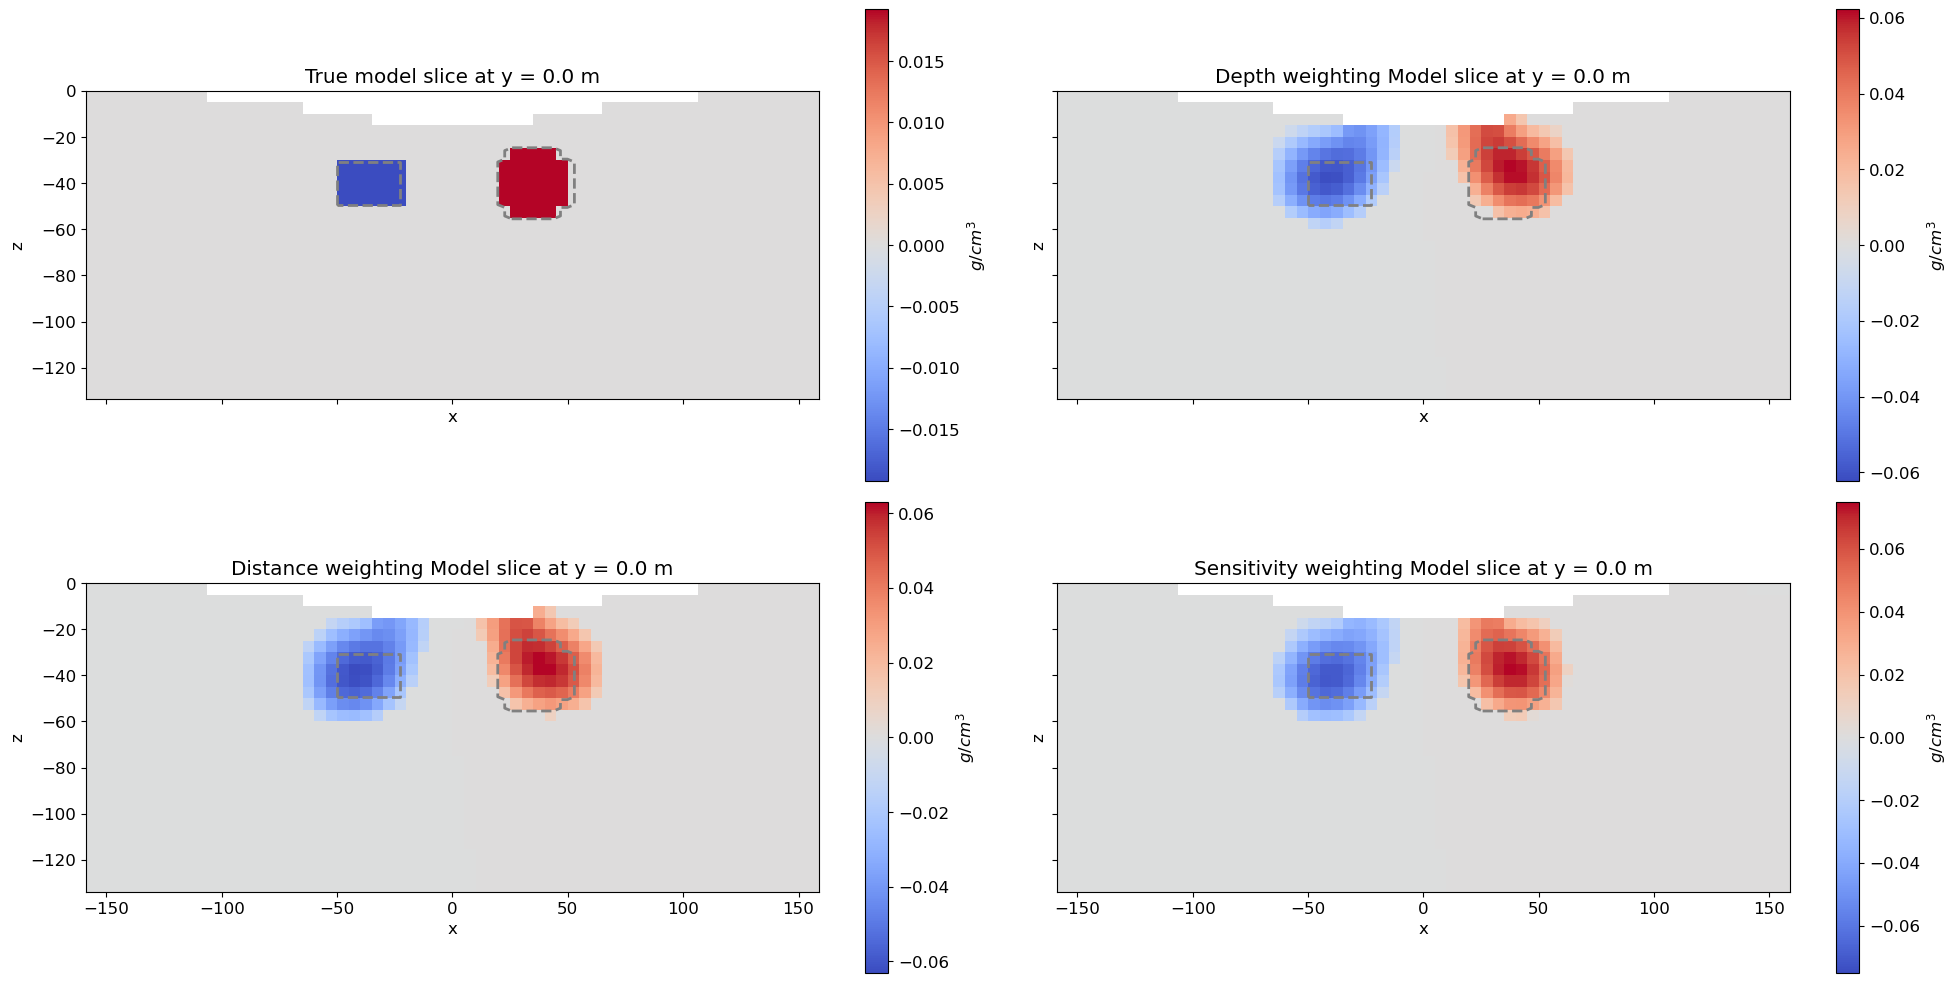

In [14]:
# Plot Models
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
ax = ax.flatten()
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
cmap = "coolwarm"
slice_y_loc = 0.0

mm = mesh.plot_slice(
    plotting_map * true_model,
    normal="Y",
    ax=ax[0],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap, "norm": norm},
)
ax[0].set_title(f"True model slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="$g/cm^3$", ax=ax[0])

# plot depth weighting result
vmax = np.abs(recovered_model_dpth).max()
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)
mm = mesh.plot_slice(
    plotting_map * recovered_model_dpth,
    normal="Y",
    ax=ax[1],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap, "norm": norm},
)
ax[1].set_title(f"Depth weighting Model slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="$g/cm^3$", ax=ax[1])

# plot distance weighting result
vmax = np.abs(recovered_model_dist).max()
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)
mm = mesh.plot_slice(
    plotting_map * recovered_model_dist,
    normal="Y",
    ax=ax[2],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap, "norm": norm},
)
ax[2].set_title(f"Distance weighting Model slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="$g/cm^3$", ax=ax[2])

# plot sensitivity weighting result
vmax = np.abs(recovered_model_sensw).max()
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)
mm = mesh.plot_slice(
    plotting_map * recovered_model_sensw,
    normal="Y",
    ax=ax[3],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap, "norm": norm},
)
ax[3].set_title(f"Sensitivity weighting Model slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="$g/cm^3$", ax=ax[3])

# shared plotting
plotting_map = maps.InjectActiveCells(mesh, ind_active, 0.0)
slice_y_ind = (
    mesh.cell_centers[:, 1] == np.abs(mesh.cell_centers[:, 1] - slice_y_loc).min()
)
for axx in ax:
    utils.plot2Ddata(
        mesh.cell_centers[slice_y_ind][:, [0, 2]],
        (plotting_map * true_model)[slice_y_ind],
        contourOpts={"alpha": 0},
        level=True,
        ncontour=2,
        levelOpts={"colors": "grey", "linewidths": 2, "linestyles": "--"},
        method="nearest",
        ax=axx,
    )
    axx.set_aspect(1)

plt.tight_layout()

Visualize weights
-----------------

Plot Weights

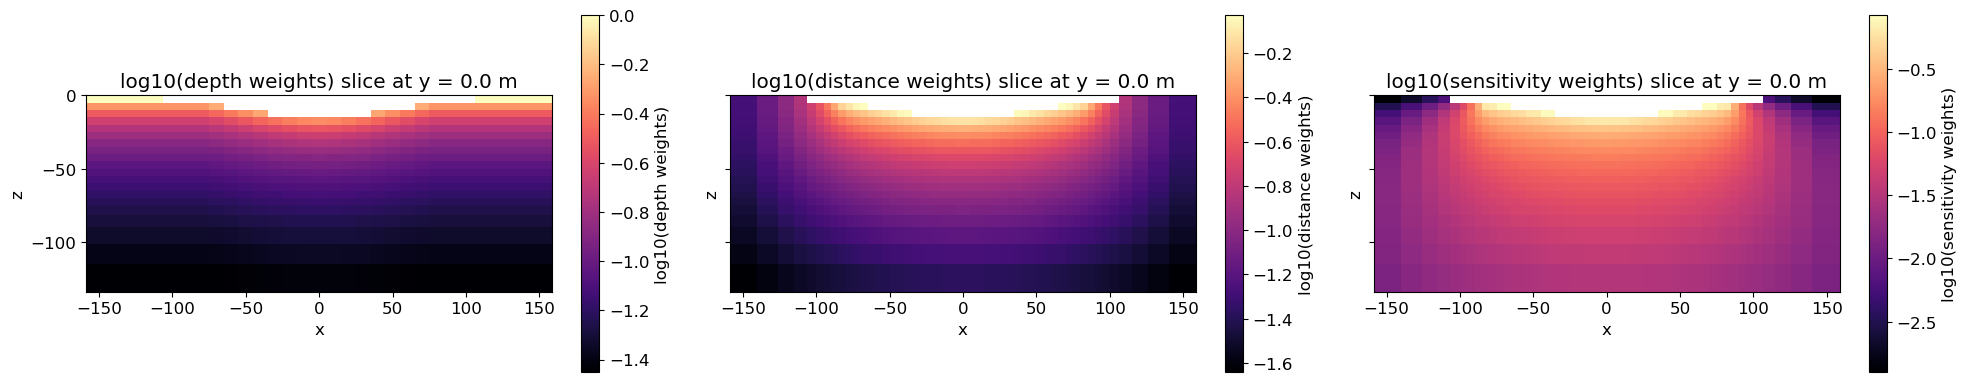

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
cmap = "magma"
slice_y_loc = 0.0

# plot depth weights
mm = mesh.plot_slice(
    plotting_map * np.log10(depth_weights),
    normal="Y",
    ax=ax[0],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap},
)
ax[0].set_title(f"log10(depth weights) slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="log10(depth weights)", ax=ax[0])

# plot distance weights
mm = mesh.plot_slice(
    plotting_map * np.log10(distance_weights),
    normal="Y",
    ax=ax[1],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap},
)
ax[1].set_title(f"log10(distance weights) slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="log10(distance weights)", ax=ax[1])

# plot sensitivity weights
mm = mesh.plot_slice(
    plotting_map * np.log10(reg_sensw.objfcts[0].get_weights(key="sensitivity")),
    normal="Y",
    ax=ax[2],
    grid=False,
    slice_loc=slice_y_loc,
    pcolor_opts={"cmap": cmap},
)
ax[2].set_title(f"log10(sensitivity weights) slice at y = {slice_y_loc} m")
plt.colorbar(mm[0], label="log10(sensitivity weights)", ax=ax[2])

# shared plotting
for axx in ax:
    axx.set_aspect(1)

plt.tight_layout()